In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [56]:
data = pd.read_csv("./steam-200k.csv", header = None, names=["id", "title", "action", "hours", "value"]) 

In [57]:
data.head()

,id,title,action,hours,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [58]:
data.describe()

,id,hours,value
count,2.000000e+05,200000.000000,200000.0
mean,1.036559e+08,17.874384,0.0
std,7.208074e+07,138.056952,0.0
min,5.250000e+03,0.100000,0.0
25%,4.738420e+07,1.000000,0.0
50%,8.691201e+07,1.000000,0.0
75%,1.542309e+08,1.300000,0.0
max,3.099031e+08,11754.000000,0.0


In [59]:
data = data.drop(columns=["value"])

In [60]:
data.id.nunique()

12393

In [ ]:
# тут посмотрим количество игр и количество покупок
num_games = data["title"].nunique()
num_purchases = data[data["action"] == "purchase"].shape[0]

num_games, num_purchases

(5155, 129511)

In [65]:
# выведем топ игр по времени, проведенном в них
playtime = data[data["action"] == "play"]
game_playtime = playtime.groupby("title")["hours"].sum().sort_values(ascending=False)

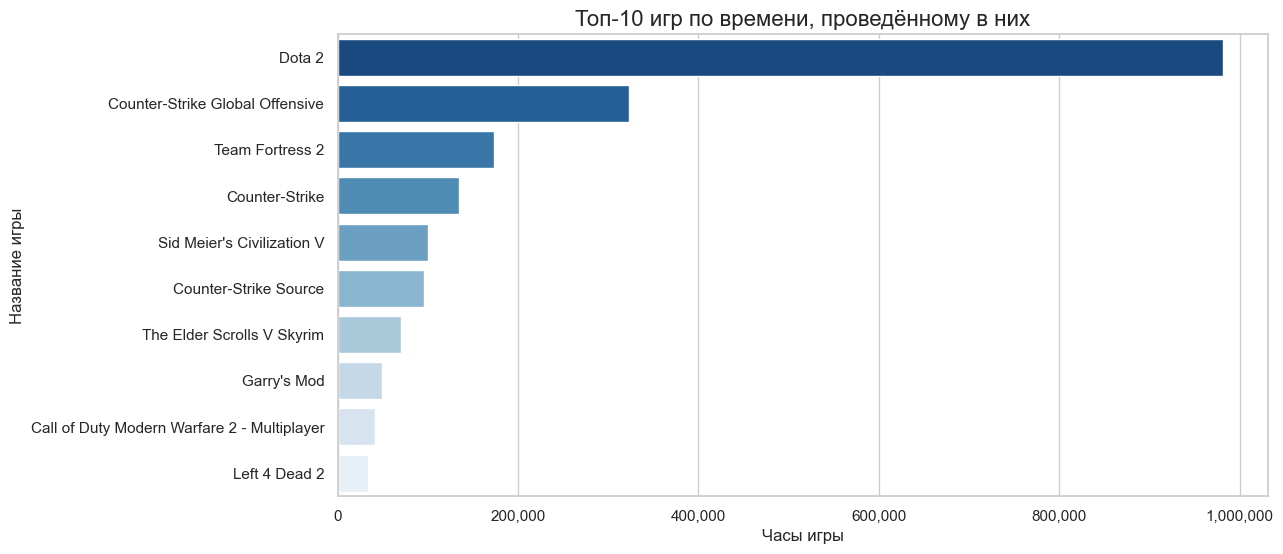

In [69]:
sns.set(style="whitegrid")

# группируем данные по играм и суммируем время, проведённое в них
game_playtime = playtime.groupby("title")["hours"].sum().sort_values(ascending=False).head(10)
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    x=game_playtime.values,
    y=game_playtime.index,
    ax=ax,
    palette="Blues_r" 
)

ax.set_title("Топ-10 игр по времени, проведённому в них", fontsize=16)
ax.set_xlabel("Часы игры", fontsize=12)
ax.set_ylabel("Название игры", fontsize=12)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.show()

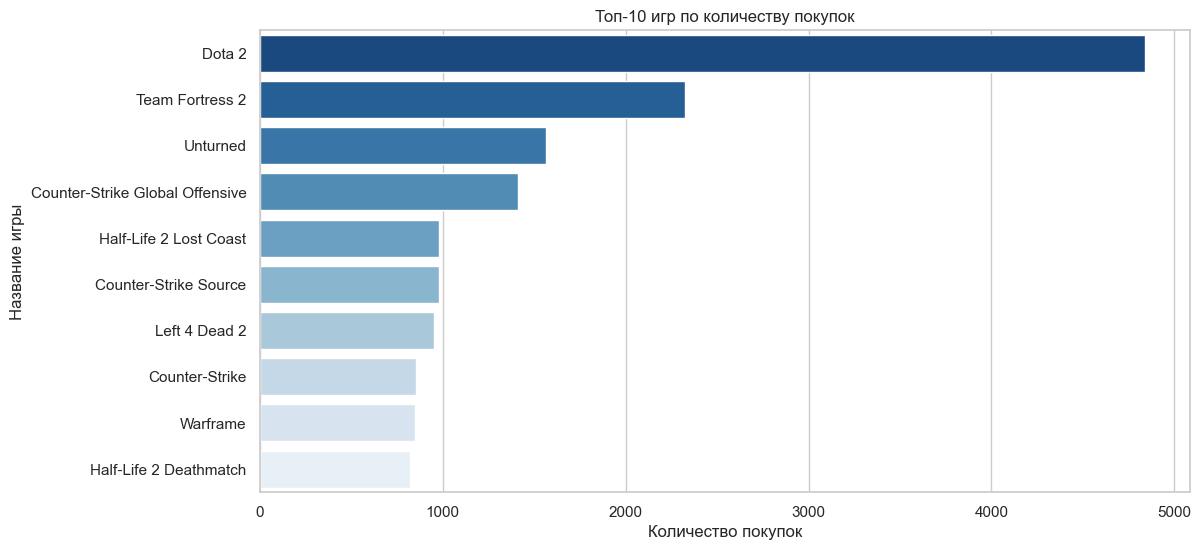

In [ ]:
sns.set(style="whitegrid")

# тут топ игр по покупкам
top_purchased_games = (
    data[data["action"] == "purchase"]["title"]
    .value_counts()
    .head(10)
)

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    x=top_purchased_games.values,
    y=top_purchased_games.index,
    ax=ax,
    palette="Blues_r"
)
ax.set_title("Топ-10 игр по количеству покупок")
ax.set_xlabel("Количество покупок")
ax.set_ylabel("Название игры")

plt.show()

In [74]:
# оплаты и игры в пересчете на юзера
purchases_per_user = data[data["action"] == "purchase"].groupby("id").size()
playtime_per_user = data[data["action"] == "play"].groupby("id")["hours"].sum()

In [78]:
purchases_df = pd.DataFrame({
    "UserID": purchases_per_user.index,
    "NumPurchases": purchases_per_user.values
})

playtime_df = pd.DataFrame({
    "UserID": playtime_per_user.index,
    "TotalPlaytime": playtime_per_user.values
})

# Объединяем данные по UserID (внутреннее соединение, чтобы оставить только общих пользователей)
user_data = pd.merge(purchases_df, playtime_df, on="UserID", how="inner")

# Нормализуем данные
scaler = StandardScaler()
user_data_scaled = scaler.fit_transform(user_data[['NumPurchases', 'TotalPlaytime']])

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


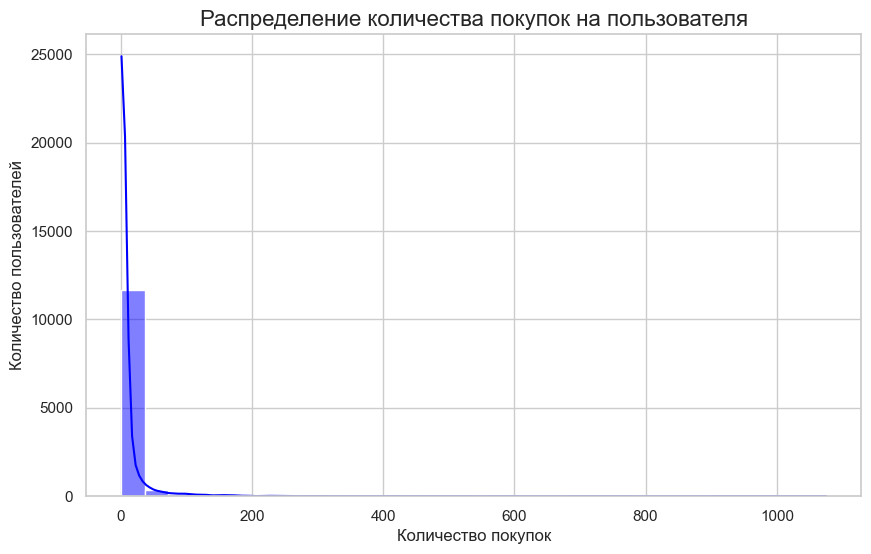

In [79]:
plt.figure(figsize=(10, 6))
sns.histplot(purchases_per_user, bins=30, kde=True, color='blue')
plt.title('Распределение количества покупок на пользователя', fontsize=16)
plt.xlabel('Количество покупок', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.show()

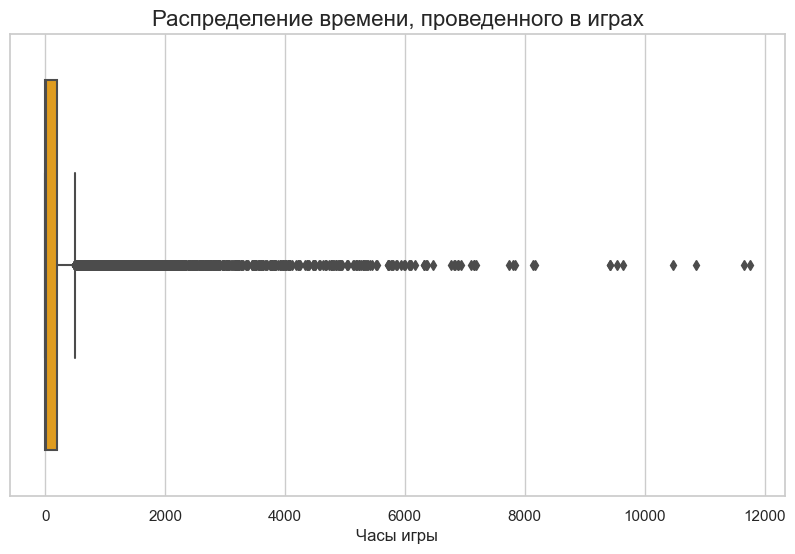

In [80]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=playtime_per_user, color='orange')
plt.title('Распределение времени, проведенного в играх', fontsize=16)
plt.xlabel('Часы игры', fontsize=12)
plt.show()

По двум графикам что выше делаем такой вывод: в основном всё же игроки приобретают не более 20-50 игр, и в целом основная доля пользователей не совсем активна.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Характеристики кластеров:
   Cluster  NumPurchases  TotalPlaytime
0        0      5.550052     135.894848
1        1    385.129032    3144.558065
2        2     60.930041    2490.383402


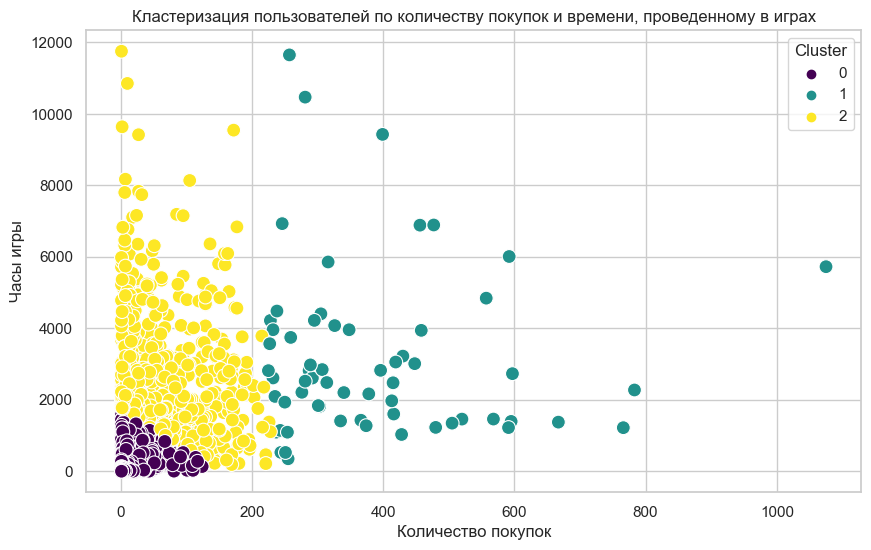

Топ-5 игр в кластере 0:
title
Dota 2                             4371
Team Fortress 2                    1898
Unturned                           1199
Counter-Strike Global Offensive     967
Counter-Strike Source               631
Name: count, dtype: int64
Топ-5 игр в кластере 1:
title
Left 4 Dead 2           58
Metro 2033              58
Terraria                52
Portal 2                51
Saints Row The Third    50
Name: count, dtype: int64
Топ-5 игр в кластере 2:
title
Dota 2                             426
Counter-Strike Global Offensive    396
Team Fortress 2                    376
Left 4 Dead 2                      326
Garry's Mod                        259
Name: count, dtype: int64


In [ ]:
# применяем K-means для кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)
user_data['Cluster'] = kmeans.fit_predict(user_data_scaled)

# анализ по кластерам
cluster_analysis = user_data.groupby('Cluster').agg({
    'NumPurchases': 'mean',
    'TotalPlaytime': 'mean'
}).reset_index()
print("Характеристики кластеров:")
print(cluster_analysis)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='NumPurchases',
    y='TotalPlaytime',
    hue='Cluster',
    data=user_data,
    palette='viridis',
    s=100
)
plt.title('Кластеризация пользователей по количеству покупок и времени, проведенному в играх')
plt.xlabel('Количество покупок')
plt.ylabel('Часы игры')
plt.show()

# посмотрим на популярные игры в каждом кластере
for cluster in user_data['Cluster'].unique():
    cluster_users = user_data[user_data['Cluster'] == cluster]['UserID']
    top_games_cluster = data[(data['id'].isin(cluster_users)) & (data['action'] == 'purchase')]['title'].value_counts().head(5)
    print(f"Топ-5 игр в кластере {cluster}:")
    print(top_games_cluster)


Ну а тут получили три группы игроков на основе их игровых паттернов, можно условно назвать их: умеренные игроки (основная доля), коллекционеры (много игр, мало времени), хардкорные геймеры (мало игр, много времени)

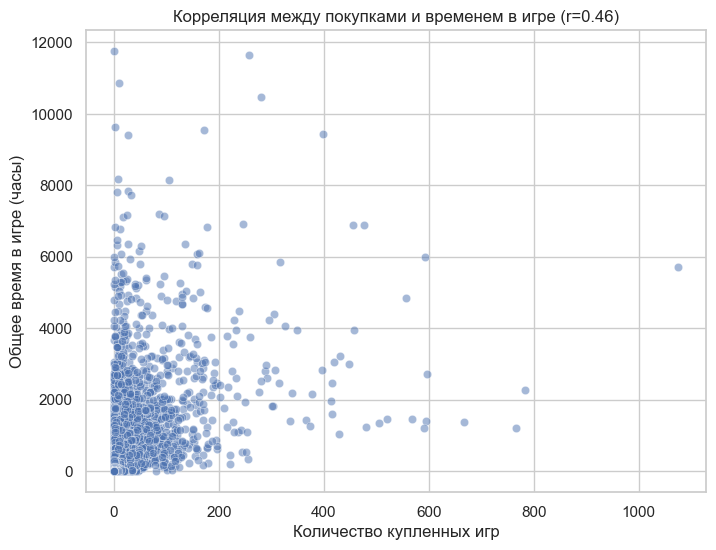

In [ ]:
correlation = purchases_per_user.corr(playtime_per_user)

fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x=purchases_per_user, y=playtime_per_user, alpha=0.5, ax=ax)
ax.set_title(f"Корреляция между покупками и временем в игре (r={correlation:.2f})")
ax.set_xlabel("Количество купленных игр")
ax.set_ylabel("Общее время в игре (часы)")

plt.show()

In [ ]:
mean_playtime = playtime_per_user.mean()
median_playtime = playtime_per_user.median()

print(f"Среднее время игры на пользователя: {mean_playtime:.2f} часов")
print(f"Медианное время игры на пользователя: {median_playtime:.2f} часов")


Среднее время игры на пользователя: 303.56 часов
Медианное время игры на пользователя: 19.50 часов


In [ ]:
for threshold in [10, 50, 100]:
    percent = (playtime_per_user > threshold).mean() * 100
    print(f"Доля игроков, сыгравших более {threshold} часов: {percent:.2f}%")

# ретеншн и отток игроков
purchased_users = data[data["action"] == "purchase"]["id"].unique()
played_users = data[data["action"] == "play"]["id"].unique()
abandoned_users = set(purchased_users) - set(played_users)
churn_rate = len(abandoned_users) / len(purchased_users) * 100
print(f"Процент пользователей, которые купили игру, но не играли: {churn_rate:.2f}%")

Доля игроков, сыгравших более 10 часов: 57.96%
Доля игроков, сыгравших более 50 часов: 39.15%
Доля игроков, сыгравших более 100 часов: 31.87%
Процент пользователей, которые купили игру, но не играли: 8.42%


In [ ]:

playtime_per_game = data[data["action"] == "play"].groupby("title")["hours"].sum()
purchases_per_game = data[data["action"] == "purchase"]["title"].value_counts()

# cоотношение часов к покупкам игры
roi = (playtime_per_game / purchases_per_game).dropna().sort_values(ascending=False)

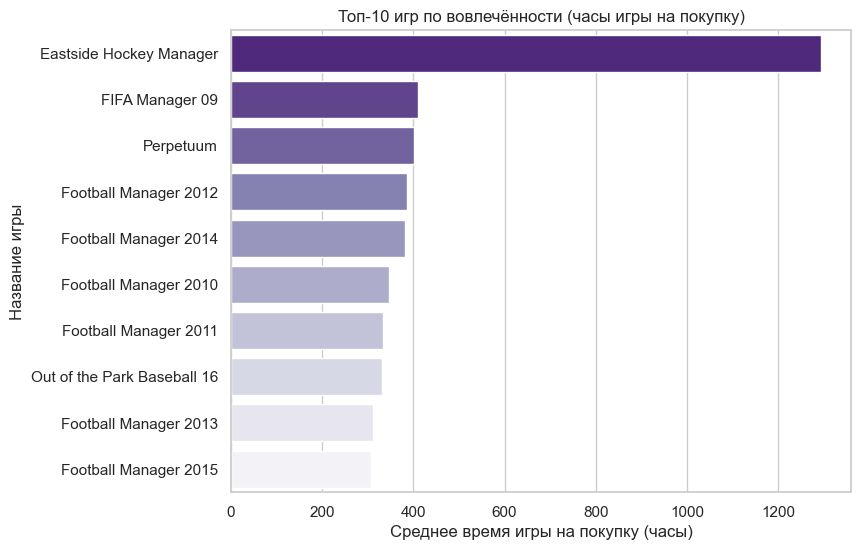

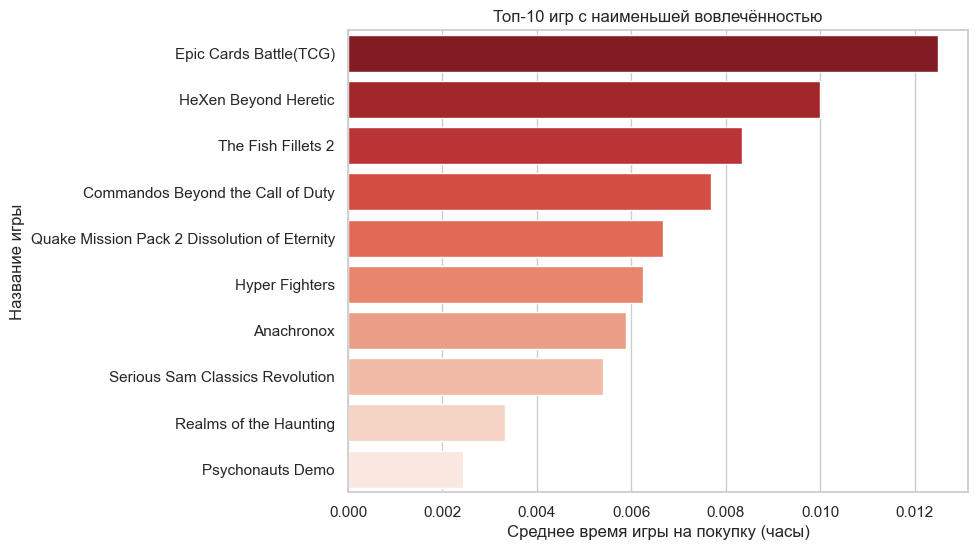

In [ ]:
# Топ-10 игр с наибольшим ROI
plt.figure(figsize=(8, 6))
sns.barplot(x=roi.head(10).values, y=roi.head(10).index, palette="Purples_r")
plt.title("Топ-10 игр по вовлечённости (часы игры на покупку)")
plt.xlabel("Среднее время игры на покупку (часы)")
plt.ylabel("Название игры")
plt.show()

# Топ-10 игр с наименьшим ROI (разочаровывающие игры)
plt.figure(figsize=(8, 6))
sns.barplot(x=roi.tail(10).values, y=roi.tail(10).index, palette="Reds_r")
plt.title("Топ-10 игр с наименьшей вовлечённостью")
plt.xlabel("Среднее время игры на покупку (часы)")
plt.ylabel("Название игры")
plt.show()

In [ ]:
popularity_vs_engagement = pd.DataFrame({
    "total_playtime": playtime_per_game,
    "total_purchases": purchases_per_game
}).dropna()

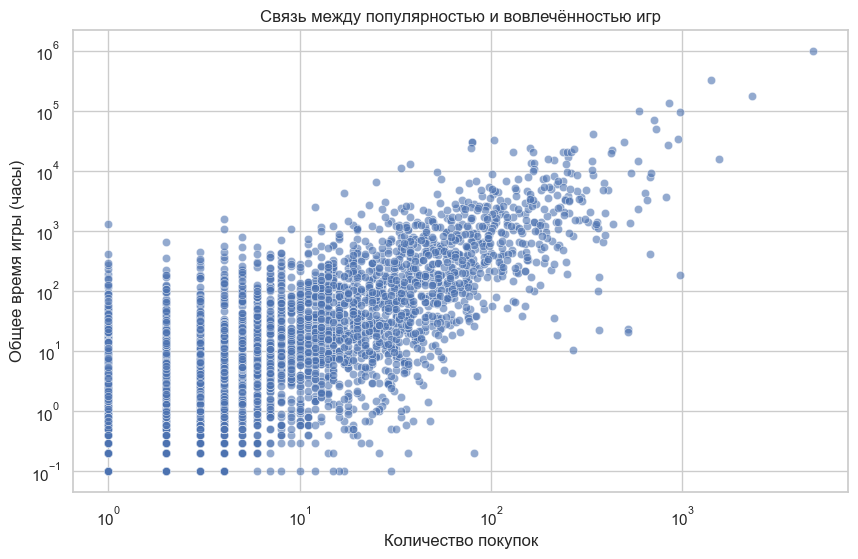

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=popularity_vs_engagement["total_purchases"], y=popularity_vs_engagement["total_playtime"], alpha=0.6)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Количество покупок")
plt.ylabel("Общее время игры (часы)")
plt.title("Связь между популярностью и вовлечённостью игр")
plt.show()